<h1>Distribution Analysis</h1><br>
Used for analysing pretrained models. Given a client id (source dataset) and precomputed distribution (from a file in saved_dist), plot two comparison histograms on differing timescales. Allows for analysis of how well a trained distribution matches the source one. Can either use the given distribution as is or remove points to the LHS of the split and instead fit a lognormal for those points.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from HelperFunctions import MultiHist
import scipy.stats as stats

In [2]:
#convenience variables
sec = 1000000000
split_time = 0.00025

#tweakable parameters
data_csv = 'data.csv' #the raw data
c_id = 4
#if using a distribution for only the RHS then this must be true, otherwise decide depending on what you are trying to test.
#setting this to true will attempt to remove any points to the LHS of the split and replace it with a lognormal distribution generated from the source data
use_lognorm = False
model_type = "Composite" #used as the title for the graphs

#file names
dist_file = f"composite_dist_c4.npz" #load
dist_folder = "saved_dist"

<h2>Data Loading</h2>

In [3]:
#prepend the folder location
dist_file = os.path.join(dist_folder, dist_file)

#load raw data
X = pd.read_csv(data_csv)
orig_times = X[(X.client_id == c_id)].time.apply(lambda x:x/sec)
orig_times.sort_values
orig_delta = np.ediff1d(orig_times)
orig_delta = orig_delta[orig_delta > 0] #remove dups
delta_mean = np.mean(orig_delta)
delta_std = np.std(orig_delta)

print(f"Orig Max Time: {orig_times.max()} seconds")
print(f"Orig Data Points: {len(orig_times)}")
print(f"mean: {delta_mean}, std: {delta_std}")

#get and process the distribution data from the file
f = np.load(dist_file, allow_pickle=True)
synth_delta = f["deltas"]
synth_times = np.cumsum(synth_delta)

print()
print(f"Synth Max Time: {synth_times.max()} seconds")
print(f"Synth Data Points: {len(synth_times)}")
print(f"mean: {np.mean(synth_delta)}, std: {np.std(synth_delta)}")

Orig Max Time: 244608.309583663 seconds
Orig Data Points: 284553
mean: 0.8975650506628737, std: 7.825000598875937

Synth Max Time: 247497.8301742107 seconds
Synth Data Points: 270000
mean: 0.9166586302748556, std: 8.686941032837108


<h2>Evaluation</h2><br>
Better combination distributions will match the shape of the original distribution closer.<br>

Note: the actual time period covered by each histogram may not excatly match the specified time period. In some cases it will be shorter since there was not enough data to fill the entire time period and thus the timeperiod has been auto-shrunk to fill the graph.

<h3>Timeline</h3>

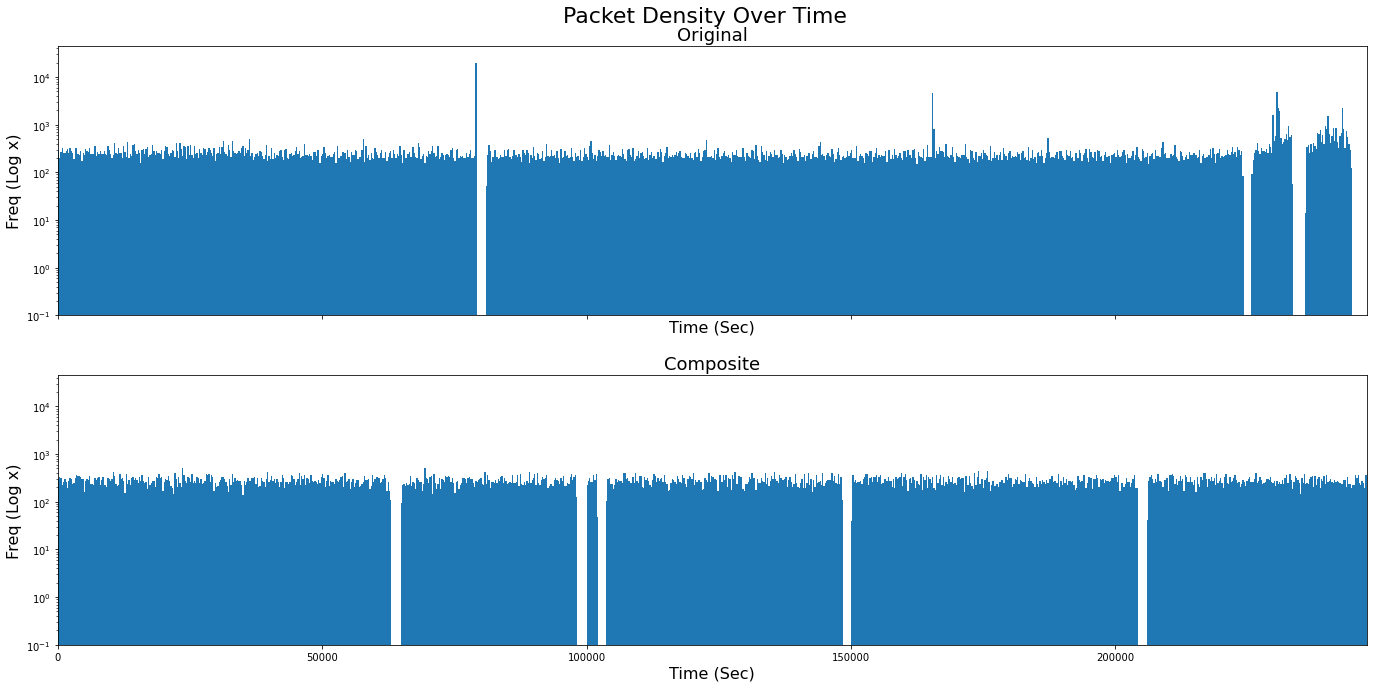

In [4]:
#density over time
MultiHist([orig_times, synth_times], title=f'Packet Density Over Time', subtitles=['Original', model_type], bins=1000, y_max=45000)

<h3>Interarrivals</h3>

orig_mean:	0.8975650506628737,	orig_std:	7.825000598875937
synth_mean:	0.9166586302748556,	synth_std:	8.686941032837108


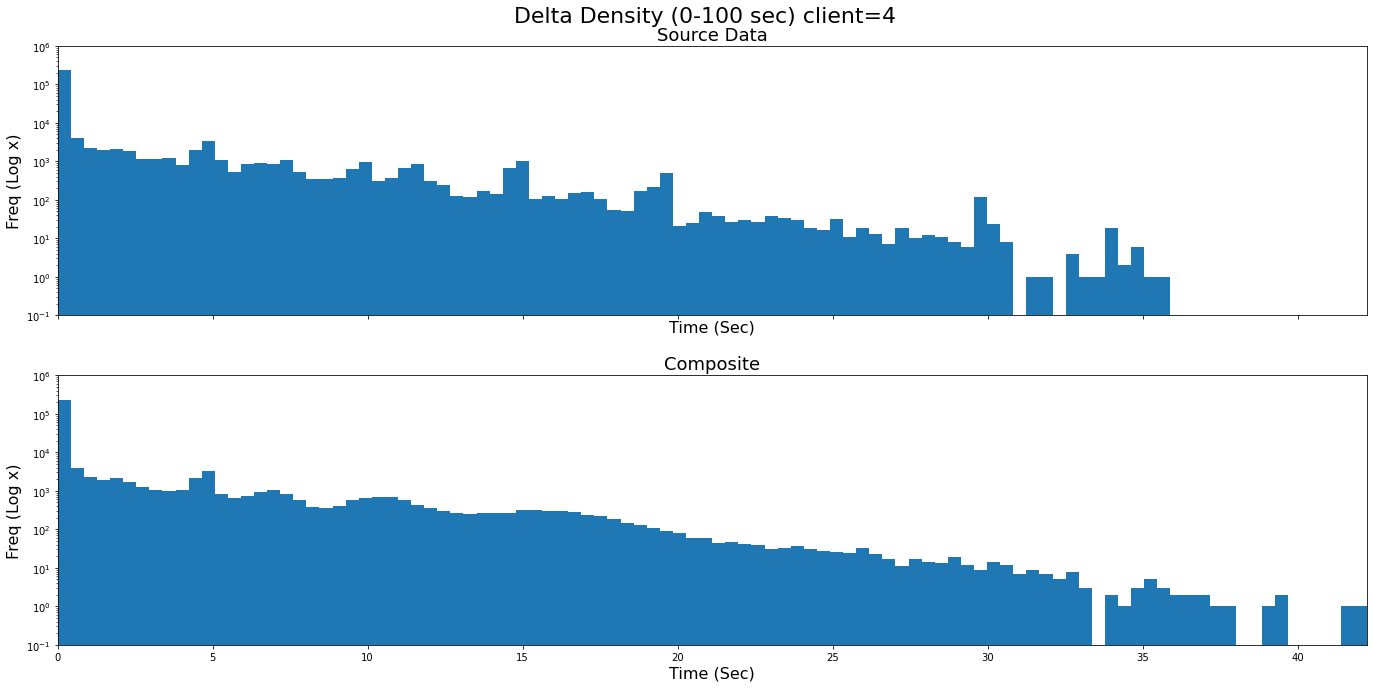

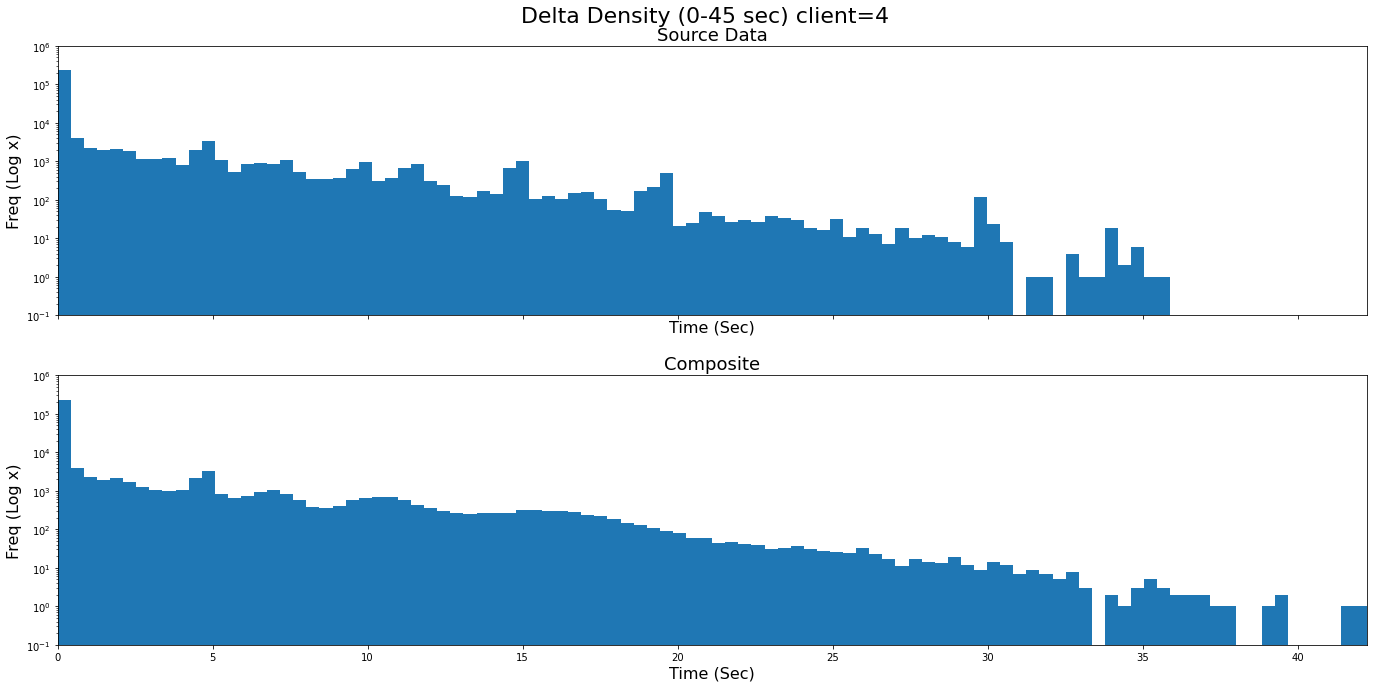

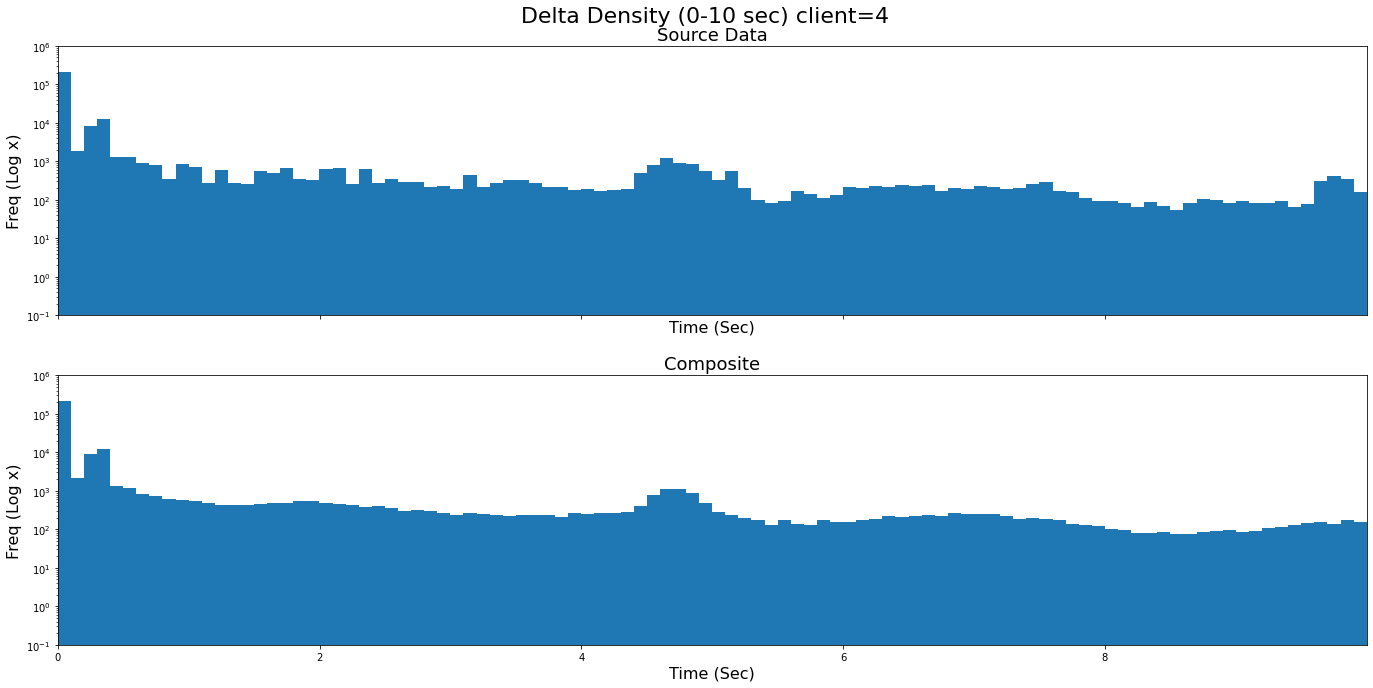

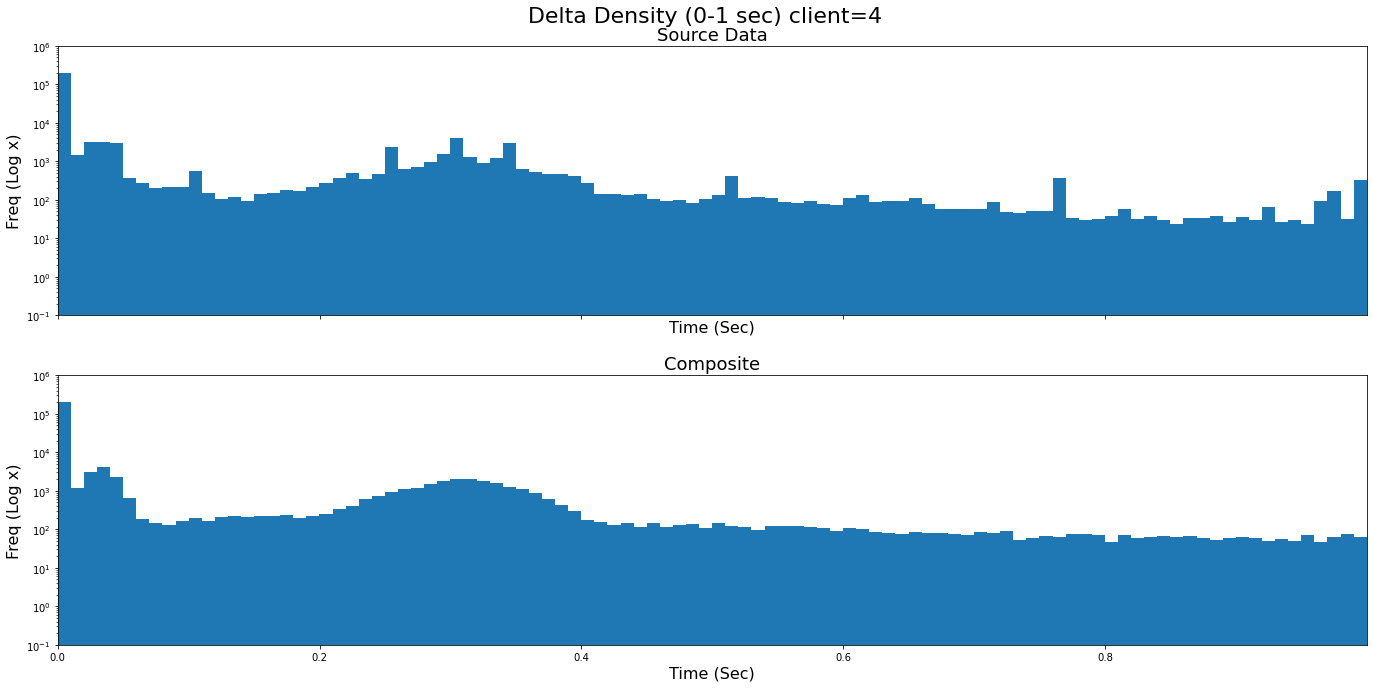

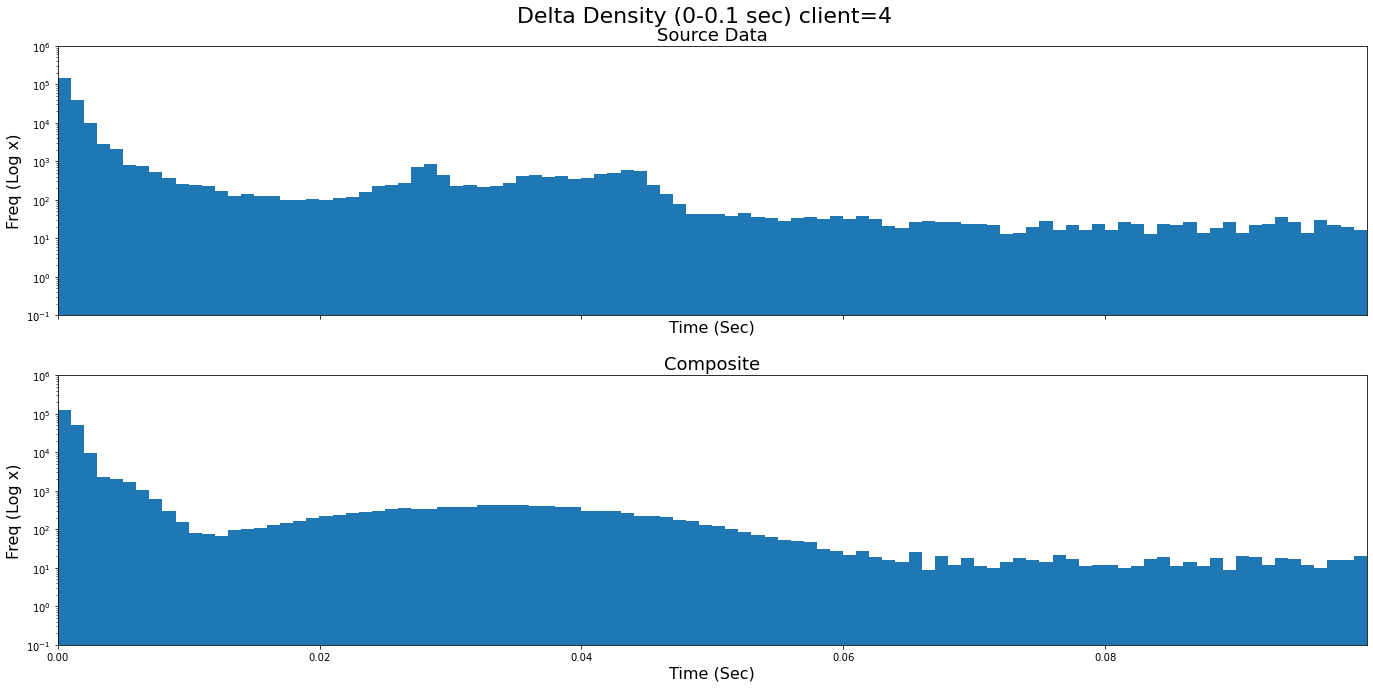

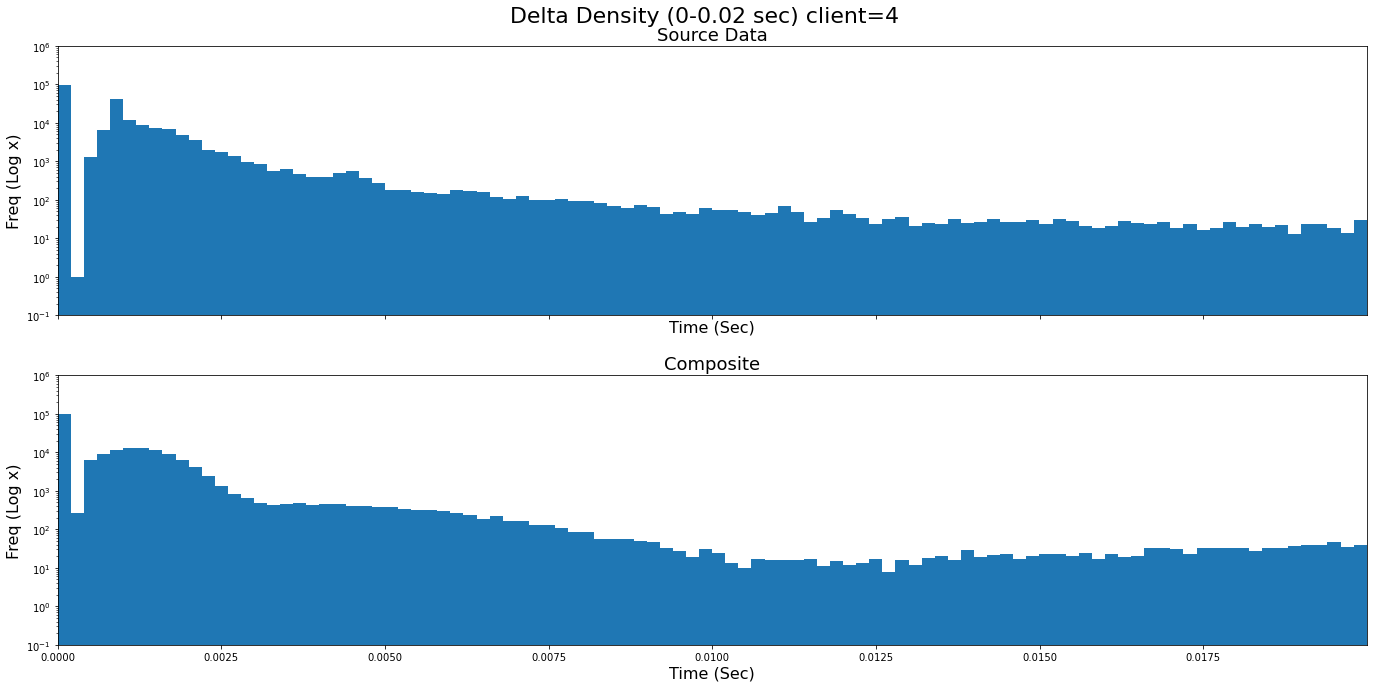

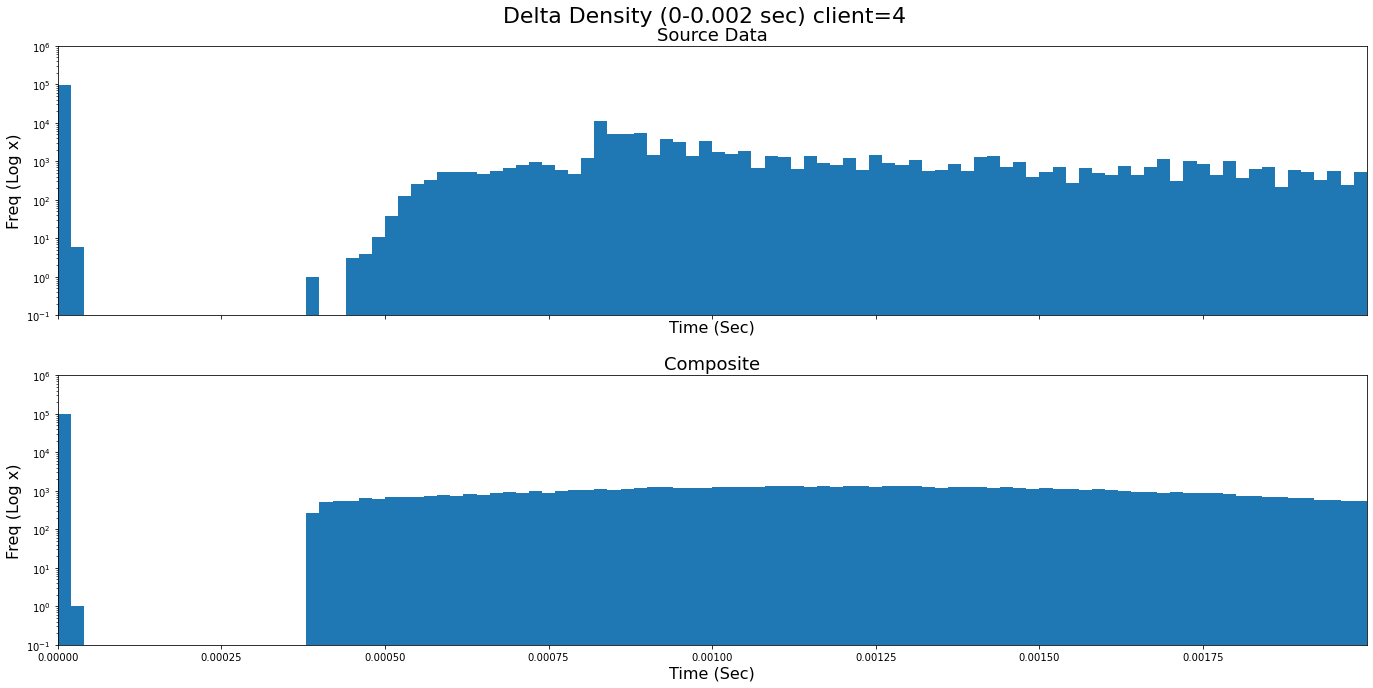

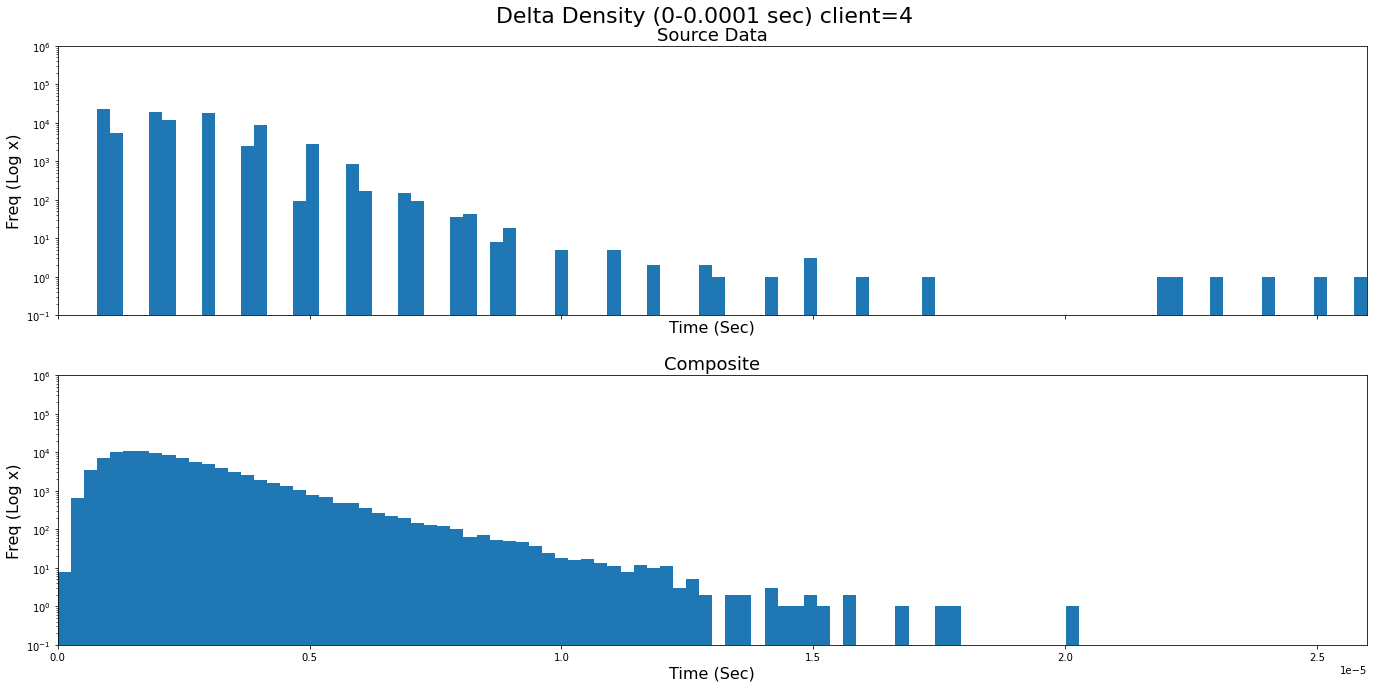

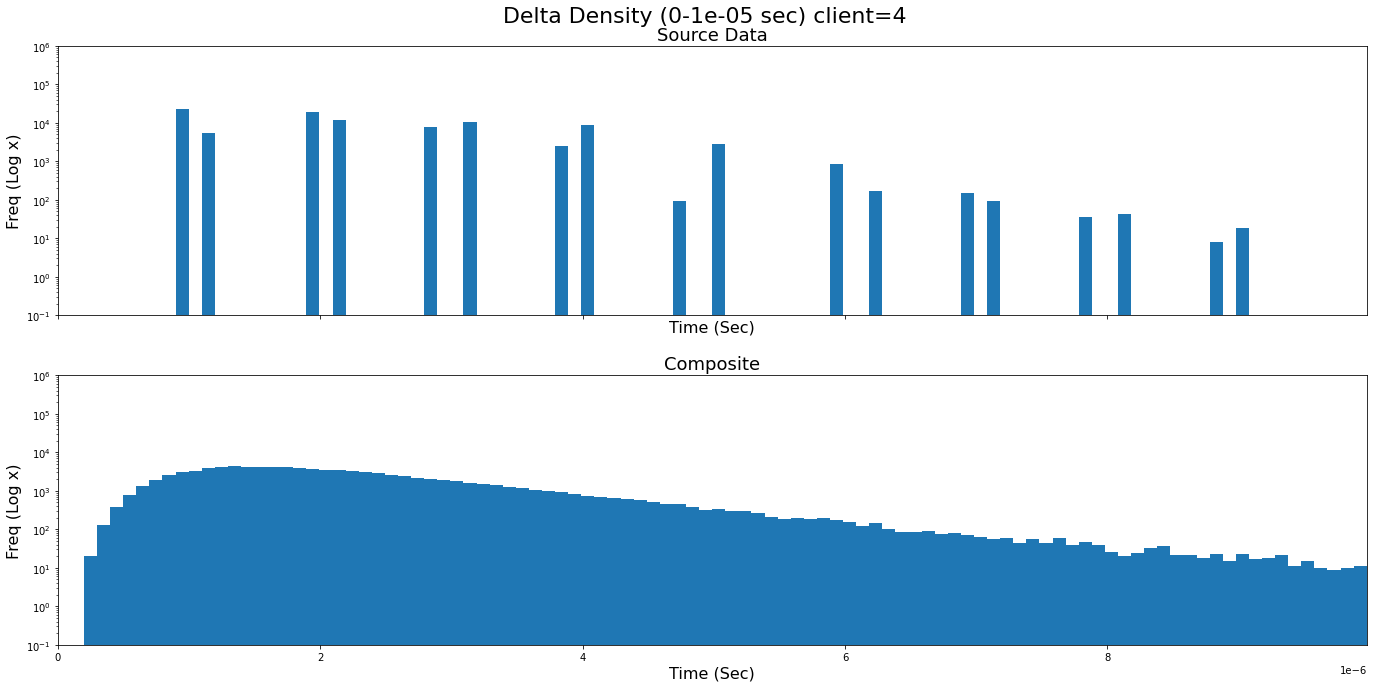

In [5]:
if (use_lognorm):
    #create the lognormal distribution and merge with the RHS
    n = np.random.lognormal(mean=np.mean(np.log(orig_delta[orig_delta < split_time])), sigma=np.std(np.log(orig_delta[orig_delta < split_time])), size=orig_delta[orig_delta < split_time].size*3)
    LHS = n[n > 0][:orig_delta[orig_delta < split_time].size]
    RHS = synth_delta[synth_delta > split_time]
    new_delta = np.concatenate((LHS, RHS))
    
    print(f"RHS_orig_mean:\t{np.mean(orig_delta[orig_delta > split_time])},\tRHS_orig_std:\t{np.std(orig_delta[orig_delta > split_time])}")
    print(f"RHS_synth_mean:\t{np.mean(RHS)},\tRHS_synth_std:\t{np.std(RHS)}")
else:
    #just use the whole distribution given
    new_delta = synth_delta
    print(f"orig_mean:\t{np.mean(orig_delta)},\torig_std:\t{np.std(orig_delta)}")
    print(f"synth_mean:\t{np.mean(new_delta)},\tsynth_std:\t{np.std(new_delta)}")
    
#generate interarrival graphs on different timescales
timescale=[100,45,10,1,0.1,0.02, 0.002, 0.0001, 0.00001]
for i in timescale:
    MultiHist([orig_delta[(orig_delta<i)], new_delta[new_delta<i]], title=f'Delta Density (0-{i} sec) client={c_id}', subtitles=['Source Data', model_type], bins=100, y_max=1000000)

<h3>QQ Graph</h3>
A qq graph of the data from the original distribution on the LHS of the split in comparison to a lognormal

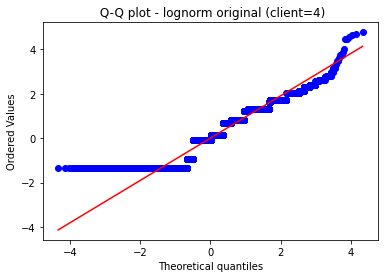

In [6]:
obs = np.log(orig_delta[(orig_delta < split_time) & (orig_delta > 1/sec)])
z1 = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z1, dist="norm", plot=plt)
plt.title(f" Q-Q plot - lognorm original (client={c_id})")
plt.show()